In [1]:
#Packages 
import numpy as np
import cartopy
import glob
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
import xarray as xr
import xroms
from matplotlib import ticker
crs = ccrs.PlateCarree()
warnings.filterwarnings("ignore") #turns off annoying warnings
#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

# The core of the analysis is done with xhistogram
from xhistogram.xarray import histogram

/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
def open_mfroms(path):
    '''
Opens multiple netcdf files with xroms
    '''
    # chunk = {"xi": -1, "eta": -1, "ocean_time": -1} 
    # chunks = {}
    # for sub in ["rho", "u", "v", "psi"]:
        # for k, v in chunk.items():
            # chunks[f"{k}_{sub}"] = v
    # chunks["ocean_time"] = chunk["ocean_time"]

    ds = xroms.open_mfnetcdf(path)
    ds,grid = xroms.roms_dataset(ds,include_cell_volume=True)
    ds.xroms.set_grid(grid)
    return ds,grid

def add_derivatives(ds, grid, q='salt'):
    '''
Analysis of velocity gradient tensor and frontogenesis function
following Hetland et al. (2025) JPO
    '''
    qs = ds[q]
    
    #############################
    # Flow and property gradients at the ocean surface
    
    ds['dqdx'] = xroms.to_rho(grid.derivative(qs.isel(s_rho=-1), 'X'), grid)    # defined at rho-points
    ds['dqdy'] = xroms.to_rho(grid.derivative(qs.isel(s_rho=-1), 'Y'), grid)    # defined at rho-points
    
    ds['dudx'] = grid.derivative(ds.isel(s_rho=-1).u, 'X', boundary='extend')  # defined at rho-points
    ds['dvdy'] = grid.derivative(ds.isel(s_rho=-1).v, 'Y', boundary='extend')  # defined at rho-points
    ds['dvdx'] = xroms.to_rho(grid.derivative(ds.isel(s_rho=-1).v, 'X', boundary='extend'), grid)  # defined at rho-points
    ds['dudy'] = xroms.to_rho(grid.derivative(ds.isel(s_rho=-1).u, 'Y', boundary='extend'), grid)  # defined at rho-points
    
    ###########################
    # Invariant flow properties
    
    # Vorticity:  v_x - u_y
    ds['zeta'] = (ds.dvdx - ds.dudy)/ds.f
    ds['zeta'].name = 'Normalized vorticity'

    # Divergence: u_x + v_y
    ds['delta'] = (ds.dudx + ds.dvdy)/ds.f
    ds['delta'].name = 'Normalized divergence'

    # Major axis of deformation
    ds['alpha'] = ( np.sqrt( (ds.dudx-ds.dvdy)**2 + (ds.dvdx+ds.dudy)**2 ) )/ds.f
    ds['alpha'].name = 'Normalized total strain'

    ##################################
    # Principle deformation components

    ds['lminor'] = 0.5 * (ds.delta - ds.alpha)
    ds['lminor'].name = 'lambda minor'

    ds['lmajor'] = 0.5 * (ds.delta + ds.alpha)
    ds['lmajor'].name = 'lambda major'
    
    #############################################
    # Along- and cross-frontal velocity gradients
    
    # angle is wrt x, so need to do arctan2(y, x)
    ds['phi_cf'] = np.arctan2(ds.dqdy, ds.dqdx)
    ds['phi_af'] = ds.phi_cf + np.pi/2.0

    ds['du_cf'] = ( ds.dudx*np.cos(ds.phi_cf)**2 + ds.dvdy*np.sin(ds.phi_cf)**2 
               + (ds.dudy + ds.dvdx)*np.sin(ds.phi_cf)*np.cos(ds.phi_cf) )/ds.f

    ds['du_af'] = ( ds.dudx*np.cos(ds.phi_af)**2 + ds.dvdy*np.sin(ds.phi_af)**2
              + (ds.dudy + ds.dvdx)*np.sin(ds.phi_af)*np.cos(ds.phi_af) )/ds.f
    
    ############################
    # The frontogenesis function
    
    # Dimensional frontogenesis function
    Dgradq_i = - ds.dudx*ds.dqdx - ds.dvdx*ds.dqdy
    Dgradq_j = - ds.dudy*ds.dqdx - ds.dvdy*ds.dqdy
    ds['Ddelq2'] = (ds.dqdx*Dgradq_i + ds.dqdy*Dgradq_j)
    ds['Ddelq2'].name = 'Frontogenesis function'

    # Density gradients squared
    ds['gradq2'] = ds.dqdx**2 + ds.dqdy**2
    ds['gradq2'].name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    ds['nFGF'] = 0.5 * ds.Ddelq2 / (ds.gradq2 * ds.f)
    ds['nFGF'].name = r'Normalized Frontogenesis Function'
    
    return ds

path = glob.glob('/pscratch/sd/b/bundzis/Beaufort_ROMS_2020_test_nosed_scratch/ocean_his_*.nc')
ds, grid = open_mfroms(path)
add_derivatives(ds,grid)

<xarray.Dataset> Size: 1TB
Dimensions:         (s_rho: 20, s_w: 21, ocean_time: 1271, tracer: 5,
                     boundary: 4, eta_rho: 206, xi_rho: 608, xi_u: 607,
                     eta_v: 205)
Coordinates: (12/23)
  * s_rho           (s_rho) float64 160B -0.975 -0.925 -0.875 ... -0.075 -0.025
  * s_w             (s_w) float64 168B -1.0 -0.95 -0.9 -0.85 ... -0.1 -0.05 0.0
  * ocean_time      (ocean_time) datetime64[ns] 10kB 2020-07-01T01:00:00 ... ...
    z_rho           (ocean_time, s_rho, eta_rho, xi_rho) float64 25GB dask.array<chunksize=(1, 20, 206, 608), meta=np.ndarray>
    z_w             (ocean_time, s_w, eta_rho, xi_rho) float64 27GB dask.array<chunksize=(1, 21, 206, 608), meta=np.ndarray>
    lon_rho         (eta_rho, xi_rho) float64 1MB dask.array<chunksize=(206, 608), meta=np.ndarray>
    ...              ...
    z_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 27GB dask.array<chunksize=(1, 21, 206, 607), meta=np.ndarray>
    z_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 27GB dask.array<chunksize=(1, 21, 205, 608), meta=np.ndarray>
    z_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 27GB dask.array<chunksize=(1, 21, 205, 607), meta=np.ndarray>
    z_rho_u         (ocean_time, s_rho, eta_rho, xi_u) float64 25GB dask.array<chunksize=(1, 20, 206, 607), meta=np.ndarray>
    z_rho_v         (ocean_time, s_rho, eta_v, xi_rho) float64 25GB dask.array<chunksize=(1, 20, 205, 608), meta=np.ndarray>
    z_rho_psi       (ocean_time, s_rho, eta_v, xi_u) float64 25GB dask.array<chunksize=(1, 20, 205, 607), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/158)
    ntimes          int32 4B ...
    ndtfast         int32 4B ...
    dt              float64 8B ...
    dtfast          float64 8B ...
    dstart          datetime64[ns] 8B ...
    nHIS            int32 4B ...
    ...              ...
    phi_af          (ocean_time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 206, 608), meta=np.ndarray>
    du_cf           (ocean_time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 206, 608), meta=np.ndarray>
    du_af           (ocean_time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 206, 608), meta=np.ndarray>
    Ddelq2          (ocean_time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 206, 608), meta=np.ndarray>
    gradq2          (ocean_time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 206, 608), meta=np.ndarray>
    nFGF            (ocean_time, eta_rho, xi_rho) float64 1GB dask.array<chunksize=(1, 206, 608), meta=np.ndarray>
Attributes: (12/53)
    file:              /pscratch/sd/b/bundzis/Beaufort_ROMS_2020_test_nosed_s...
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             One-dimension (vertical) Sediment Toy
    var_info:          /global/homes/b/bundzis/Repos/COAWST/ROMS/External/var...
    ...                ...
    compiler_command:  /opt/cray/pe/mpich/8.1.30/ofi/gnu/12.3/bin/mpif90
    compiler_flags:    -frepack-arrays -fallow-argument-mismatch -fallow-argu...
    tiling:            032x008
    history:           ROMS/TOMS, Version 4.1, Friday - June 27, 2025 - 10:32...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_st...
    CPP_options:       BEAUFORT_2020_TEST_NOSED, ANA_BPFLUX, ANA_BSFLUX, ANA_...

### Make a single frame 

In [4]:
crs = ccrs.LambertConformal(
    central_longitude=-148,
    central_latitude=70.5,
    standard_parallels=(30, 60)  # usually two standard parallels
)
t = 100
rvort = ds.zeta[t].compute()

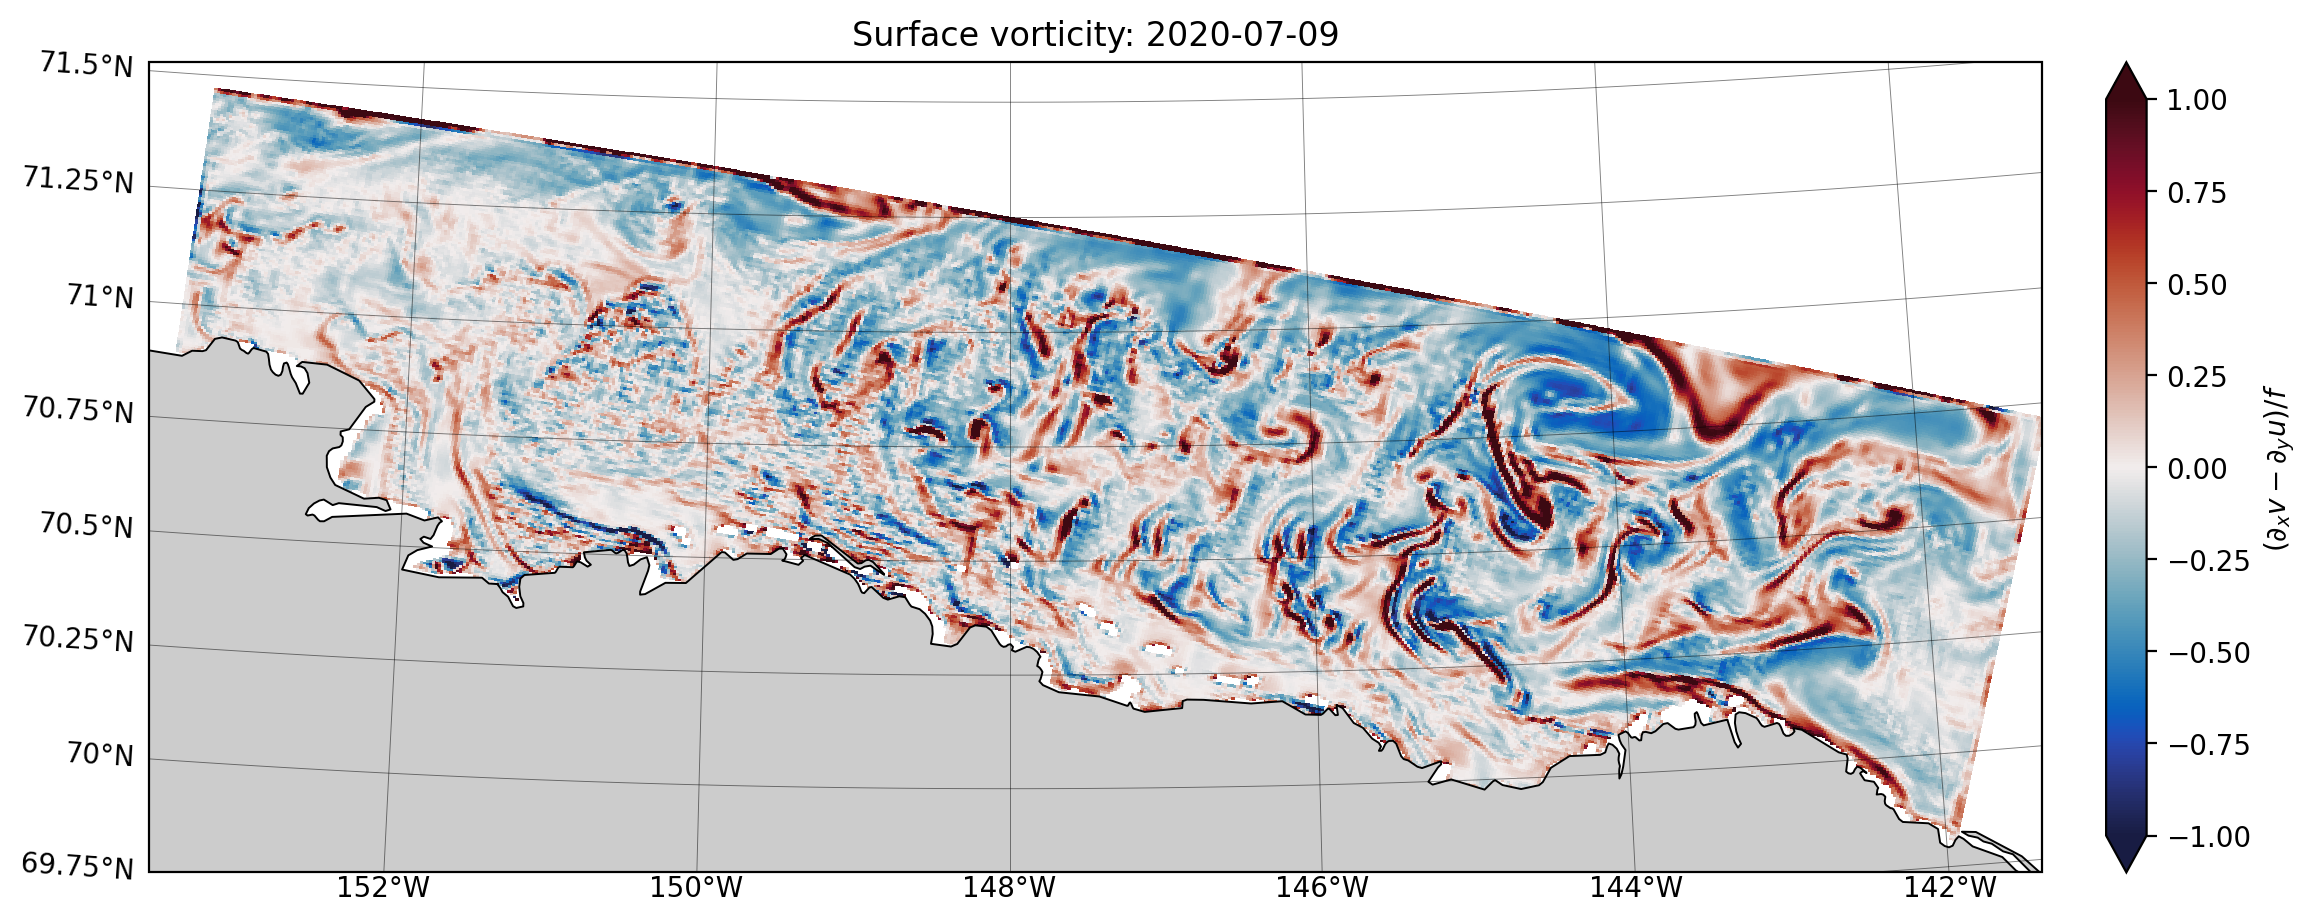

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,4.5), dpi=200,
                       constrained_layout=True, 
                       subplot_kw={'projection': crs})

m = rvort.plot(
    x='lon_rho', y='lat_rho',
    ax=ax,
    cmap=cmo.balance, transform=ccrs.PlateCarree(),
    add_colorbar=False, facecolor="gray",
    vmin = -1,vmax=1,
)
fig.colorbar(m,ax=ax,extend='both',
             label=r'($\partial_x v - \partial_y u)/f$',
             pad=0.03)

# Set extent and map features
ax.set_extent([-153.5,-141.4,69.75, 71.5],ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            facecolor='0.8'), linewidth=.7)
ax.coastlines(resolution='10m', linewidth=.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=True, 
                  x_inline=False, y_inline=False, 
                  linewidth=0.33, color='k',alpha=0.5)
gl.right_labels = gl.top_labels = False
gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

ax.set_title('Surface vorticity: '+str(ds.ocean_time.values[t])[:10]) #Only display yyyy-mm-dd
fig.canvas.draw()

### Now make an animation in parallel

In [16]:
from joblib import Parallel, delayed

def plot_frame(t):
    fig, ax = plt.subplots(1, 1, 
                           figsize=(12,4.5),
                           constrained_layout=True, 
                           subplot_kw={'projection': crs})
    # This can be changed depending on how often you want to save frames. Useful if you want 
    # to coarsen the output frequency
    i = t // 1  # This assumes `t` is incrementing by 1 (e.g., range(0, len(rv.Time), 1))
    rvort = ds.zeta[t]

    m = rvort.plot(
        x='lon_rho', y='lat_rho',
        ax=ax,
        cmap=cmo.balance, transform=ccrs.PlateCarree(),
        add_colorbar=False, facecolor="gray",
        vmin = -1,vmax=1,
    )

    fig.colorbar(m,
                 ax=ax,
                 extend='both',
                 label=r'($\partial_x v - \partial_y u)/f$',
                 pad=0.03)

    # Set extent and map features
    ax.set_extent([-153.5,-141.4,69.75, 71.5],ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                facecolor='0.8'), linewidth=.7)
    ax.coastlines(resolution='10m', linewidth=.7)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True, 
                      x_inline=False, y_inline=False, 
                      linewidth=0.33, color='k',alpha=0.5)
    gl.right_labels = gl.top_labels = False
    gl.xlocator = ticker.FixedLocator([-152, -150,-148,-146,-144,-142])
    gl.xlabel_style = {'rotation': 0, 'ha': 'center'}

    ax.set_title('Surface vorticity: '+str(ds.ocean_time.values[t])[:10]) #Only display yyyy-mm-dd

    # Comment this out if you are printing a lot of frames... jupyter will be unhappy
    print(f'/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_{i}.png')
   
    plt.savefig(
        f'/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_{i}.png',
        dpi=200, bbox_inches='tight'
    )
    plt.close(fig)  # Close to avoid memory leaks

# Run 8 plots in parallel at once (adjust n_jobs based on your CPU). If you did this on a compute node you can set it to be 128!!
Parallel(n_jobs=8)(delayed(plot_frame)(t) for t in range(0, len(ds.ocean_time), 1))

/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d

/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_2.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_10.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_17.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_25.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_3.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_11.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_19.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_27.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_0.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_8.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_13.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_21.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_29.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_1.png
/pscratch/sd/d/dylan617/b

/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_5.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_14.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_22.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_30.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_38.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d

/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_37.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_45.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_48.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_55.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_36.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_47.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_53.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_61.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_40.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_49.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_56.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_63.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_39.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_50.png
/pscratch/sd/d/dylan

/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_43.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_58.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_66.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_73.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d

/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_64.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_78.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_79.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_80.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_84.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_91.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_70.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_81.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_85.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_92.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_72.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_82.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_87.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_95.png
/pscratch/sd/d/dylan

/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_71.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_83.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_89.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_97.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_105.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_76.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_90.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_98.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_106.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_77.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_93.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_100.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_107.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d

/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_99.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_113.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_114.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_116.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_104.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_117.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_119.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_125.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_101.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_115.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_118.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_123.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_130.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_108.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_120.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_128.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_135.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_110.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_124.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_131.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_136.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_109.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_121.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_129.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_138.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_112.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_126.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_133.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_139.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_111.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_127.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_134.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_140.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d

/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_122.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_146.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_147.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_148.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_149.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_132.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_150.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_152.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_154.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_137.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_153.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_155.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_158.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_142.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_156.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_161.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_167.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_141.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_157.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_162.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_168.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_143.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_160.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_166.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_171.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_145.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_164.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_170.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_176.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_144.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_163.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_169.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_173.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_178.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_151.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_175.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_179.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_182.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_184.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_159.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_183.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_185.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_187.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_190.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_165.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_186.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_189.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_191.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_172.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_192.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_195.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_199.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_174.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_194.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_198.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_202.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_177.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_197.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_201.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_206.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_180.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_200.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_204.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_209.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_181.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_203.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_207.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_211.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_188.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_210.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_213.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_217.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_219.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_193.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_216.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_218.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_221.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_196.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_220.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_222.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_225.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_205.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_226.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_228.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_230.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_208.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_229.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_231.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_236.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_212.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_232.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_237.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_240.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_214.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_233.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_238.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_242.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_215.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_234.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_239.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_243.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_247.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_223.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_244.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_249.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_253.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_224.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_246.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_250.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_254.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_227.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_251.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_255.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_257.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_235.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_259.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_261.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_263.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_241.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_262.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_264.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_266.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_245.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_265.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_268.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_271.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_274.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_248.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_269.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_273.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_276.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_252.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_272.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_275.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_278.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_256.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_277.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_281.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_286.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_258.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_280.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_285.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_288.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_291.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_260.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_283.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_287.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_289.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_293.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_297.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_267.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_292.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_294.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_298.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_279.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_301.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_304.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_270.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_295.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_299.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_302.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_306.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_282.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_305.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_308.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_312.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_284.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_307.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_310.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_314.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_317.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_290.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_313.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_315.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_319.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_296.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_318.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_320.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_323.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_303.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_325.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_328.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_331.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_300.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_324.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_326.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_329.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_333.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_309.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_330.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_334.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_337.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_311.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_332.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_335.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_340.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_316.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_338.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_341.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_344.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_322.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_346.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_349.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_352.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_321.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_343.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_347.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_350.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_353.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_327.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_351.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_354.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_357.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_359.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_336.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_358.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_361.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_365.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_339.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_360.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_362.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_367.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_372.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_342.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_364.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_368.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_373.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_345.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_366.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_370.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_375.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_348.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_369.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_374.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_377.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_356.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_380.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_384.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_355.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_378.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_382.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_385.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_388.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_363.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_387.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_389.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_391.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_393.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_395.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_371.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_392.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_394.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_396.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_376.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_397.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_400.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_405.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_381.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_402.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_406.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_410.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_383.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_403.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_407.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_412.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_379.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_398.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_404.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_408.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_413.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_386.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_409.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_414.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_418.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_421.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_390.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_415.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_420.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_422.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_426.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_399.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_423.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_427.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_429.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_401.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_424.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_428.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_431.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_434.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_411.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_432.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_435.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_437.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_416.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_436.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_440.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_444.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_448.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_419.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_441.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_445.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_449.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_417.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_439.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_443.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_446.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_450.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_425.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_447.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_451.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_455.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_430.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_454.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_457.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_460.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_433.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_458.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_461.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_463.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_438.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_462.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_465.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_468.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_470.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_442.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_466.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_469.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_471.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_452.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_472.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_475.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_479.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_453.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_474.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_478.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_482.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_459.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_480.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_483.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_487.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_456.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_477.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_481.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_484.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_489.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_464.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_486.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_490.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_493.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_496.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_467.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_491.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_495.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_498.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_473.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_497.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_500.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_503.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_476.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_501.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_504.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_505.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_508.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_485.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_507.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_510.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_514.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_488.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_509.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_511.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_516.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_492.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_512.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_517.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_520.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_494.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_515.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_518.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_522.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_499.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_523.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_526.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_529.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_502.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_525.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_528.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_531.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_534.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_506.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_530.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_532.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_535.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_513.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_536.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_538.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_540.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_519.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_541.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_543.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_547.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_521.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_542.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_546.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_550.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_554.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_524.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_545.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_549.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_553.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_557.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_533.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_555.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_558.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_562.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_527.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_548.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_551.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_556.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_560.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_565.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_537.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_561.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_566.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_569.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_539.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_564.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_568.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_572.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_544.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_571.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_574.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_577.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_552.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_576.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_578.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_580.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_559.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_581.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_583.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_587.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_563.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_582.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_585.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_588.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_591.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_567.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_586.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_589.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_593.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_598.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_570.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_590.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_594.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_599.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_602.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_579.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_604.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_608.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_573.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_595.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_600.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_605.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_609.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_575.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_597.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_601.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_606.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_610.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_584.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_611.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_614.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_617.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_592.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_616.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_618.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_621.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_596.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_619.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_622.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_624.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_603.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_625.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_627.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_612.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_631.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_635.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_607.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_626.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_629.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_632.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_636.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_613.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_633.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_637.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_640.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_615.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_634.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_638.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_642.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_646.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_620.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_643.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_647.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_650.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_623.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_645.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_648.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_652.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_656.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_628.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_649.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_653.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_657.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_659.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_630.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_654.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_658.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_661.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_639.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_663.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_666.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_669.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_641.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_664.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_667.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_670.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_644.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_668.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_671.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_675.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_651.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_673.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_676.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_678.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_681.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_655.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_677.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_680.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_683.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_660.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_682.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_685.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_690.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_662.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_684.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_687.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_691.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_665.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_689.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_692.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_694.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_672.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_696.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_699.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_701.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_704.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_674.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_697.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_700.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_703.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_706.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_679.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_702.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_705.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_708.png


/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_693.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_715.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_695.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_707.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_698.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_686.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_709.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_712.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_716.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_688.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_710.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_713.png
/pscratch/sd/d/dylan617/beaufort_roms/animations/surface_zetaf_717.png
Traceback (most recent call last):
  File "/global/u2/d/dylan617/miconda3/env

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7fb94be336a0>
Traceback (most recent call last):
  File "/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 
Process LokyProcess-167:
Traceback (most recent call last):
  File "/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/u2/d/dylan617/miconda3/envs/xroms/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py", line 478, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
                              ^^^^^^^^^^^^^^^^^^

### To turn this into a movie, you can use ```ffmpeg``` in a terminal. 
```cd``` to your dir with the frames, then run:
```ffmpeg -r 16 -start_number 0  -i surface_zetaf_%d.png -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p ../beaufort_v2_zetaf.mp4```
This uses 16 fps starting from frame zero and creates the movie up one directory. It can still take a while (at least a few minutes) to get through the entire simulation. 

### To do - expand this to include temperature and salinity. We want to start building more intuition about what the tracers look like 